In [1]:
# PC-level analysis

# 1. Encoding as is, PC on semantic embedding, prediction on semantic PC


In [2]:
import os, sys
import torch
import numpy as np
from utils import p2r, word2sense, regression, listdir, image_to_tensor, Subject, cv_regression_w2s
from train import mean_condition_features
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import scipy.stats as stats
from collections import OrderedDict 
import matplotlib.pyplot as plt
import copy
from feature_extractors import AlexNetConv5
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm import tqdm
import warnings; warnings.simplefilter('ignore')


In [3]:
# Load visual features
alexnet = torch.load('features_conv5.pth') # dict with 1470 * 12544 features

alexnet_reshape = copy.deepcopy(alexnet)
for item in alexnet_reshape:
    alexnet_reshape[item] = np.reshape(alexnet_reshape[item], (256, 7, 7))
                             
vgg = torch.load('features_vgg16_conv5.pth')

In [4]:
# Load semantic embeddings
with open('ThingsWrd2Sns.txt', 'r', encoding='utf-8') as txt:
    temp = txt.readlines()
nDim = 2250
wordlist = [line.split(',')[0] for idx, line in enumerate(temp) if idx != 0] # create word list
word2sense = {new_list: np.zeros((1, nDim)) for new_list in wordlist} # create (word: embedding) dictionary
for i, line in enumerate(temp):
    if i == 0:
        continue
    embedding = line.split(',')
    embedding.remove('\n')
    embedding_float = np.array(([float(j) for j in embedding[1:]]))
    word2sense[embedding[0]] = embedding_float

embeddings = OrderedDict(word2sense)

In [5]:
# # Wordvec filtered by CM
# wordvec = {}
# with open('ThingsWrd2Vec_subset.txt', 'r', encoding='utf-8') as txt:
#     temp = txt.readlines()

# for i, wv in enumerate(temp):
#     if i == 0:
#         continue
#     w = (temp[i].split(','))[0]
#     if w in word2sense:
#         wordvec[w] = temp[i].split(',')[1:]
#         wordvec[w][-1] = wordvec[w][-1].replace('\n', '')

# for wv in wordvec:
#     wordvec[wv] = np.array(wordvec[wv]).astype(np.float)

# embeddings = wordvec
# features = {item: alexnet[item] for item in alexnet.keys() if item in wordvec}

In [6]:
embedding_nPC = 100
embedding_stacked = np.stack([condition_embedding for condition, condition_embedding \
                         in OrderedDict(embeddings).items()])

#embedding_reduced = embedding_stacked

In [11]:
# Stack data
rois = ['LOC', 'PPA', 'EVC'] 
layers = ['conv5'] #'conv1', 'conv5', 'fc6', 'conv1_r', 'conv5_r', 'fc6_r'
subjects = ['subj001/', 'subj002/', 'subj003/', 'subj004/'] #subj001/ , 'subj002/', 'subj003/', 'subj004/'
random_subjects = ['subj001/', 'subj002/', 'subj003/', 'subj004/']

weighttype = ["real", "random"]
predictpath = {
    "real": "predictedvgg/",
    "random": "predictedvgg_random/"
}

# Initialize r values
roi_r_set = {}
random_r_set = {}

# Permutation repeated many times
#perm_r_set = []
# for i in range(10, 100):
#     weighttype.append("perm" + str(i))
#     predictpath["perm" + str(i)] = "predicted1023/predictedperm" + str(i) + "/"
#     perm_r_set.append({})

# print(weighttype)
# print(predictpath)

for weight in weighttype:
    if weight == "random":
        subjects = random_subjects
    else:
        subjects = ['subj001/', 'subj002/', 'subj003/', 'subj004/']
    for roi in rois:
        roi_r = []
        for layer in layers:
            sub_voxel_regressor = {}

            for subj in subjects:
                path = predictpath[weight]
                fmri_path = path + subj + roi + "_" + layer
                fmri_path = os.path.join(os.getcwd(), fmri_path) 

                conditions = sorted(listdir(fmri_path))
                condition_voxels = {}
                for condition in conditions:
                    if condition.split('/')[-1] in embeddings.keys():
                        file_name = listdir((os.path.join(fmri_path, condition)))[0]
                        file_path = os.path.join(fmri_path, condition, file_name)
                        condition_voxels[condition] = np.load(file_path) 
                voxel_regressor = np.stack([condition_voxel for condition, condition_voxel in OrderedDict(condition_voxels).items()])
                sub_voxel_regressor[subj] = voxel_regressor

                #print(sub_voxel_regressor[subj].shape)
            all_voxel_regressor = np.hstack([sub_voxel_regressor[s] for s in subjects])
            #print(all_voxel_regressor.shape)

            for pc in tqdm(range(10, 80, 10), total=7, position=0, leave=True):
                #pc = None
                features = all_voxel_regressor

                kf = KFold(n_splits = 9)
                rs = []
                for train_index, test_index in kf.split(features):
                    train_features = features[train_index,]
                    test_features =  features[test_index,]
                    train_embeddings = embedding_stacked[train_index,]
                    test_embeddings = embedding_stacked[test_index,]

                    if pc is not None:
                        pca = PCA(n_components=pc)
                        pca.fit(train_features)   
                        train_features = pca.transform(train_features)
                        test_features = pca.transform(test_features)

                    #pca_sem = PCA(n_components=embedding_nPC)
                    #pca_sem.fit(train_embeddings)
                    #train_embeddings = pca_sem.transform(train_embeddings)
                    #test_embeddings = pca_sem.transform(test_embeddings)
                    #train_embeddings = np.stack([embedding for i, embedding in enumerate(embedding_reduced) if i in train_index])
                    #test_embeddings = np.stack([embedding for i, embedding in enumerate(embedding_reduced) if i in test_index])

                    weights, r = regression(train_features, train_embeddings, test_features, test_embeddings, l2=0.0)
                    rs.append(r)

                rs = np.array(rs)
                voxel_mean_r = np.nanmean(rs, axis=0) # mean across k folds 

                roi_r.append(voxel_mean_r)

            #if subj == 'random/':
            #random_r_set[roi] = roi_r
            #else:
            if weight == "real":
                roi_r_set[roi] = roi_r
            elif weight == "random":
                random_r_set[roi] = roi_r
            elif "perm" in weight:
                i = int(weight.strip(string.ascii_letters))
                print(i)
                perm_r_set[i][roi] = roi_r

100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


In [12]:
# dimensionality score
r_threshold = p2r(0.05/2250, 1470)
#r_threshold = p2r(0.05/300, 312)

# Compute alternate metrics for semantic dimensionality score

roi_dim_set = {}
roi_max_set = {}
roi_mean_set = {}
roi_med_set = {}

for roi in rois:
    roi_dim = []
    roi_max = []
    roi_mean = []
    roi_med = []
    for dim_pred in roi_r_set[roi]:
        dim_pred = np.array(dim_pred)
        dim_pred_score = np.sum(dim_pred > r_threshold)
        dim_max = np.nanmax(dim_pred)
        dim_mean = np.nanmean(np.array(dim_pred))
        dim_med = np.nanmedian(np.array(dim_pred))
        roi_dim.append(dim_pred_score)
        roi_max.append(dim_max)
        roi_mean.append(dim_mean)
        roi_med.append(dim_med)
    roi_dim_set[roi] = roi_dim
    roi_max_set[roi] = roi_max
    roi_mean_set[roi] = roi_mean
    roi_med_set[roi] = roi_med

random_dim_set = {}
random_max_set = {}
random_mean_set = {}
random_med_set = {}

for roi in rois:
    random_dim = []
    random_max = []
    random_mean = []
    random_med = []
    for dim_pred in random_r_set[roi]:
        dim_pred = np.array(dim_pred)
        dim_pred_score = np.sum(dim_pred > r_threshold)
        dim_max = np.nanmax(dim_pred)
        dim_mean = np.nanmean(np.array(dim_pred))
        dim_med = np.nanmedian(np.array(dim_pred))
        random_dim.append(dim_pred_score)
        random_max.append(dim_max)
        random_mean.append(dim_mean)
        random_med.append(dim_med)
    random_dim_set[roi] = random_dim 
    random_max_set[roi] = random_max
    random_mean_set[roi] = random_mean
    random_med_set[roi] = random_med
    
# perm_dim_set = []
# perm_max_set = []
# perm_mean_set = []
# perm_med_set = []
# for i in range(50):

#     perm_dim_set.append({})
#     perm_max_set.append({})
#     perm_mean_set.append({})
#     perm_med_set.append({})

#     for roi in rois:
#         perm_dim = []
#         perm_max = []
#         perm_mean = []
#         perm_med = []
#         for dim_pred in perm_r_set[i][roi]:
#             dim_pred = np.array(dim_pred)
#             dim_pred_score = np.sum(dim_pred > r_threshold)
#             dim_max = np.nanmax(dim_pred)
#             dim_mean = np.nanmean(np.array(dim_pred))
#             dim_med = np.nanmedian(np.array(dim_pred))
#             perm_dim.append(dim_pred_score)
#             perm_max.append(dim_max)
#             perm_mean.append(dim_mean)
#             perm_med.append(dim_med)
#         perm_dim_set[i][roi] = perm_dim 
#         perm_max_set[i][roi] = perm_max
#         perm_mean_set[i][roi] = perm_mean
#         perm_med_set[i][roi] = perm_med

In [13]:
print(roi_dim_set['EVC'])
print(roi_dim_set['LOC'])
print(roi_dim_set['PPA'])

print(random_dim_set['EVC'])
print(random_dim_set['LOC'])
print(random_dim_set['PPA'])


[306, 392, 419, 433, 432, 450, 440]
[330, 416, 441, 451, 453, 456, 446]
[327, 428, 459, 451, 450, 454, 449]
[199, 269, 301, 305, 316, 317, 328]
[202, 249, 285, 300, 313, 325, 319]
[209, 253, 289, 313, 311, 311, 312]


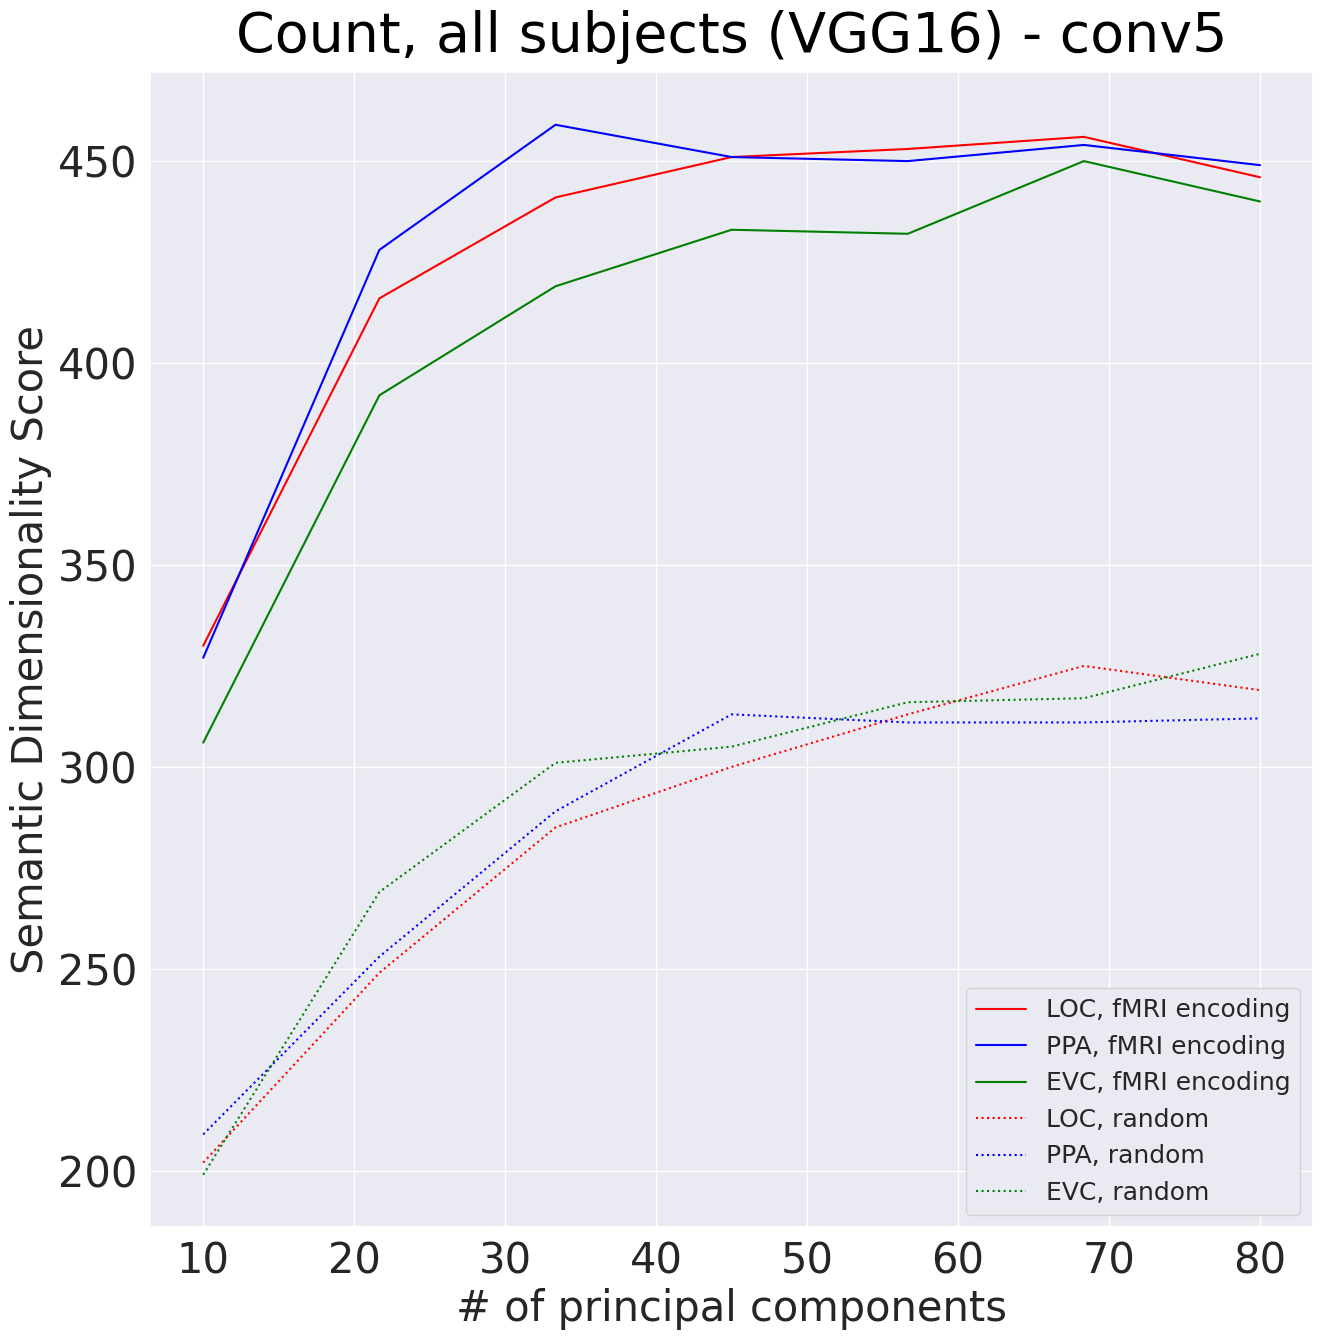

In [14]:
layeridx = {
    #"conv1": 0,
    #"conv5": 1,
    "conv5": 0,
    #"fc6": 1,
    #"fc6": 1
}
nPC = 7
for layer in layeridx:
    idx = layeridx[layer]
    x = np.linspace(10, 80, nPC)
    plt.figure(figsize=(15,15))

    title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
      'verticalalignment':'bottom'} # Bottom vertical alignment for more space
    axis_font = {'fontname':'Arial', 'size':'30'}
    sns.set()

    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(30)
    plt.xlabel('# of principal components', **axis_font)
    plt.ylabel('Semantic Dimensionality Score', **axis_font)
    plt.title("Count, all subjects (VGG16) - " + layer, **title_font)

    plt.plot(x, roi_dim_set['LOC'][nPC*(idx):nPC*(idx+1)], '-', color='red', label='LOC, fMRI encoding')
    plt.plot(x, roi_dim_set['PPA'][nPC*(idx):nPC*(idx+1)], '-', color='blue', label='PPA, fMRI encoding')
    plt.plot(x, roi_dim_set['EVC'][nPC*(idx):nPC*(idx+1)], '-', color='green', label='EVC, fMRI encoding')
    #plt.plot(x, roi_dim_set['PFS'][nPC*idx:nPC*(idx+1)], '-', color='maroon', label='PFS, fMRI encoding')
    #plt.plot(x, roi_dim_set['LOCPFS'][nPC*idx:nPC*(idx+1)], '-', color='grey', label='LOC+PFS, fMRI encoding')

    plt.plot(x, random_dim_set['LOC'][nPC*idx:nPC*(idx+1)], ':', color='red', label='LOC, random')
    plt.plot(x, random_dim_set['PPA'][nPC*idx:nPC*(idx+1)], ':', color='blue', label='PPA, random')
    plt.plot(x, random_dim_set['EVC'][nPC*idx:nPC*(idx+1)], ':', color='green', label='EVC, random')
#    plt.plot(x, random_dim_set['PFS'][nPC*idx:nPC*(idx+1)], ':', color='maroon', label='PFS, random ')
    #plt.plot(x, random_dim_set['LOCPFS'][nPC*idx:nPC*(idx+1)], ':', color='grey', label='LOC+PFS, random')

    #plt.plot(x, roi_dim_set['FFA'][nPC*(idx):nPC*(idx+1)], '-', color='orange', label='FFA, fMRI encoding')
    #plt.plot(x, roi_dim_set['FFAOFASTS'][nPC*(idx):nPC*(idx+1)], '-', color='purple', label='FFAOFASTS, fMRI encoding')

    #plt.plot(x, random_dim_set['FFA'][nPC*idx:nPC*(idx+1)], ':', color='orange', label='FFA, random')
    #plt.plot(x, random_dim_set['FFAOFASTS'][nPC*idx:nPC*(idx+1)], ':', color='purple', label='FFAOFASTS, random')
    
#     plt.plot(x, perm_dim_set[0]['LOC'][nPC*idx:nPC*(idx+1)], '-.', color='red', label='LOC, permuted')
#     plt.plot(x, perm_dim_set[0]['PPA'][nPC*idx:nPC*(idx+1)], '-.', color='blue', label='PPA, permuted')
#     plt.plot(x, perm_dim_set[0]['EVC'][nPC*idx:nPC*(idx+1)], '-.', color='green', label='EVC, permuted')

#     for i in range(1, 50):
#         plt.plot(x, perm_dim_set[i]['LOC'][nPC*idx:nPC*(idx+1)], '-.', color='red', label='_nolegend_')
#         plt.plot(x, perm_dim_set[i]['PPA'][nPC*idx:nPC*(idx+1)], '-.', color='blue', label='_nolegend_')
#         plt.plot(x, perm_dim_set[i]['EVC'][nPC*idx:nPC*(idx+1)], '-.', color='green', label='_nolegend_')
  
    
    plt.legend(prop={'size': 18});

    #plt.savefig('figures0923/SemanticDimensionality_face_' + layer + '.png')
    sns.reset_defaults()

In [ ]:
#roi_d = [[221, 52, 48], [211, 49, 46], [189, 41, 42]] #word2sense - before
#random_d = [[157, 49, 46], [159, 48, 43], [165, 43, 41]] #word2sense - before
roi_d = [[221, 71, 61], [211, 60, 57], [189, 47, 47]] #word2sense - after
random_d = [[157, 58, 55], [159, 52, 48], [165, 55, 54]] #word2sense - after


#roi_d = [[158, 20, 20], [147, 19, 19], [159, 19, 19]] #word2vec
#random_d = [[1, 2, 2], [4, 2, 2], [0, 1, 1]] #word2vec

X = np.arange(3)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, roi_d[0], color = 'g', width = 0.1, label='EVC')
ax.bar(X + 0.10, random_d[0], color = 'lightgreen', width = 0.1, label='EVC random', hatch='/')
ax.bar(X + 0.2, roi_d[1], color = 'r', width = 0.1, label='LOC')
ax.bar(X + 0.3, random_d[1], color = 'pink', width = 0.1, label='LOC random', hatch='/')
ax.bar(X + 0.40, roi_d[2], color = 'b', width = 0.1, label='PPA')
ax.bar(X + 0.50, random_d[2], color = 'lightblue', width = 0.1, label='PPA random', hatch='/')
plt.xticks(X+0.25, ('all semantic dimensions', 'top 200 semantic pc', 'top 100 semantic pc'))
plt.legend(prop={'size': 12});
plt.title("Count, all subjects (VGG16) - without PCA on fMRI-identified subspace")
